# Capstone Project - Segmenting and Clustering Districts in London
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will **explore London Districts**. Specifically, this report will be targeted to stakeholders interested in moving to **London, UK**, who would like to choose a neighborhood based on the type of venues present at close proximity.

We will use data science tools to generate clusters of similar neighborhoods, therefore allowing our client to more easily investigate the different areas.

## Data <a name="data"></a>


The following data sources were used:
* List of London postcode areas was obtained from **Wikipedia**
* Coordinates of London and the different postcode districts was obtained using the **Geocoder Python package**
* Number of venues and their category in every district area was obtained using **Foursquare API**

## Methodology <a name="methodology"></a>

In first step of our analysis we have collected the required **data: location and type (category) of the most common venues in London Districts**.

Second step in our analysis was the calculation and exploration of '**venue frequency**' across different district areas.

In third and final step, we created **clusters of locations that contain similar most common venues** using Kmeans clustering. This will allow our client to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal home location.

## Analysis <a name="analysis"></a>

### Part 1- Web scraping

Here, we import the data with London postcodes and respective District Names, from wikipedia page: https://en.wikipedia.org/wiki/London_postal_district

In [1]:
import pandas as pd
import numpy as np

In [2]:
from bs4 import BeautifulSoup # this module helps in web scrapping.
import requests  # this module helps us to download a web page

In [3]:
url = "https://en.wikipedia.org/wiki/London_postal_district"

In [4]:
data  = requests.get(url).text 

In [5]:
soup = BeautifulSoup(data,"html5lib")  # create a soup object using the variable 'data'

In [6]:
#find a html table in the web page
table = soup.find_all('table') # in html table is represented by the tag <table>

In [12]:
df=pd.DataFrame({"District":[],"Postcode districts and district names":[]})

for row in table[1].findAll('td'):
    
    if row.a:
        pass
    else:
        for child in row.descendants:
            if child.name != 'br':
                #print("child=" + str(child))
                #print(child.name)
                if child.name== 'i':
                    district= child.text
                    continue
                if child.name== 'b':
                    postcode=str(child).strip('\n').strip('<b>').strip('</b>')
                else:
                    postcode=str(child).strip('\n')
                df2 = pd.DataFrame({"District":[district],"Postcode districts and district names":[postcode]})
                df= df.append(df2, ignore_index = True)
                #print(df)


df= df[df['District']!= df['Postcode districts and district names']]
df.drop_duplicates(inplace=True, ignore_index=True)

#df.reset_index(inplace=True)
df

,District,Postcode districts and district names
0,Eastern,E1 Head district
1,Eastern,E2 Bethnal Green
2,Eastern,E3 Bow
3,Eastern,E4 Chingford
4,Eastern,E5 Clapton
...,...,...
116,Paddington,W12 Shepherds Bush
117,Paddington,W13 West Ealing
118,Paddington,W14 West Kensington
119,Western Central,WC1 Head district


We now clean and format the data in a way that will facilitate its use afterwards.

In [13]:
df['Postcode']= df['Postcode districts and district names'].str.split(' ')
df['Postcode']=df['Postcode'].apply(lambda x: x[1:] if ('') in x else x)
df

,District,Postcode districts and district names,Postcode
0,Eastern,E1 Head district,"[E1, Head, district]"
1,Eastern,E2 Bethnal Green,"[E2, Bethnal, Green]"
2,Eastern,E3 Bow,"[E3, Bow]"
3,Eastern,E4 Chingford,"[E4, Chingford]"
4,Eastern,E5 Clapton,"[E5, Clapton]"
...,...,...,...
116,Paddington,W12 Shepherds Bush,"[W12, Shepherds, Bush]"
117,Paddington,W13 West Ealing,"[W13, West, Ealing]"
118,Paddington,W14 West Kensington,"[W14, West, Kensington]"
119,Western Central,WC1 Head district,"[WC1, Head, district]"


In [14]:
df.loc[104:106]
df.drop([105], axis=0, inplace=True)
df.reset_index(inplace = True)

In [15]:
df['Postcode districts and district names']=df['Postcode'].apply(lambda x: (' ').join(x[1:]) )
#df['Postcode']=df['Postcode'].apply(lambda x: x[1])
postcodes=df['Postcode']
for i in range(len(postcodes)):
    #print(i)
    postcodes[i]=postcodes[i][0]

postcodes
df['Postcode']=postcodes
df

C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,District,Postcode districts and district names,Postcode
0,0,Eastern,Head district,E1
1,1,Eastern,Bethnal Green,E2
2,2,Eastern,Bow,E3
3,3,Eastern,Chingford,E4
4,4,Eastern,Clapton,E5
...,...,...,...,...
115,116,Paddington,Shepherds Bush,W12
116,117,Paddington,West Ealing,W13
117,118,Paddington,West Kensington,W14
118,119,Western Central,Head district,WC1


In [16]:
df.shape

(120, 4)

In [17]:
df.rename(columns={"Postcode districts and district names": "District Name"}, inplace=True)
df

,index,District,District Name,Postcode
0,0,Eastern,Head district,E1
1,1,Eastern,Bethnal Green,E2
2,2,Eastern,Bow,E3
3,3,Eastern,Chingford,E4
4,4,Eastern,Clapton,E5
...,...,...,...,...
115,116,Paddington,Shepherds Bush,W12
116,117,Paddington,West Ealing,W13
117,118,Paddington,West Kensington,W14
118,119,Western Central,Head district,WC1


In [18]:
df[df['District Name']=='South Kensington']

,index,District,District Name,Postcode
90,90,South Western,South Kensington,SW7


### Part 2- Geospatial Coordinates

We use Python's Geocoder package to obtain geospatial coodinates of London's Postcodes.

In [24]:
# Geocoder starts here
# Defining a function to use --> get_latlng()'''
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# Geocoder ends here

In [27]:
coord= pd.DataFrame()
coord['Postcode']=df['Postcode']
coord

,Postcode
0,E1
1,E2
2,E3
3,E4
4,E5
...,...
115,W12
116,W13
117,W14
118,WC1


In [35]:
lats=[]
longs=[]
for code in coord['Postcode']:
    x,y= get_latlng(code)
    lats.append(x)
    longs.append(y)

In [36]:
coord['Latitude']=lats
coord['Longitude']=longs

In [37]:
coord

,Postcode,Latitude,Longitude
0,E1,51.52022,-0.05431
1,E2,51.52669,-0.06257
2,E3,51.52702,-0.02594
3,E4,51.61780,-0.00934
4,E5,51.55897,-0.05323
...,...,...,...
115,W12,51.50645,-0.23691
116,W13,51.51453,-0.31951
117,W14,51.49568,-0.20993
118,WC1,51.52450,-0.12273


In [38]:
london = pd.merge(df,coord,on='Postcode')
london

,index,District,District Name,Postcode,Latitude,Longitude
0,0,Eastern,Head district,E1,51.52022,-0.05431
1,1,Eastern,Bethnal Green,E2,51.52669,-0.06257
2,2,Eastern,Bow,E3,51.52702,-0.02594
3,3,Eastern,Chingford,E4,51.61780,-0.00934
4,4,Eastern,Clapton,E5,51.55897,-0.05323
...,...,...,...,...,...,...
115,116,Paddington,Shepherds Bush,W12,51.50645,-0.23691
116,117,Paddington,West Ealing,W13,51.51453,-0.31951
117,118,Paddington,West Kensington,W14,51.49568,-0.20993
118,119,Western Central,Head district,WC1,51.52450,-0.12273


### Part 3- Explore and cluster the districts in London. 

In [23]:
#conda install -c conda-forge geocoder

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\ASUS\anaconda3

  added / updated specs:
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.0               |   py37h03978a9_1         3.1 MB  conda-forge
    geocoder-1.38.1            |             py_1          53 KB  conda-forge
    ratelim-0.1.6              |             py_2           6 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be INSTALLED:

  geocoder           conda-forge/noarch::geocoder-1.38.1-py_1
  ratelim            conda-forge/noarch::ratelim-0.1.6-py_2

The following packages will be UPDATED:

  conda                                4.9.2-py37h03978a9_0 --> 4.10.0-py37h03978a9_1




conda-4.10.0         | 3.1 MB    |    

In [19]:
import folium # map rendering library

In [30]:
#conda install -c conda-forge geopy

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\ASUS\anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          98 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0




geographiclib-1.50   | 34 KB     |            |   0% 
geographiclib-1.50   | 34 KB     | ####7      |  47% 
geographiclib-1.50   | 34 KB     | ########## | 100% 

geopy-2.1.0          | 64 KB     |            |   0% 
geopy-2.1.0          

In [20]:
import geocoder # import geocoder

In [21]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [23]:
address = 'LONDON, LDN'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.4806033, -0.1086343.


#### Create a map of London with districts superimposed on top.

In [39]:
# create map of New York using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(london['Latitude'], london['Longitude'], london['District'], london['District Name']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

We utilize the Foursquare API to explore the neighborhoods and segment them.

In [40]:
@secre
CLIENT_ID = '4HHYFVRFBKPQQMALBDTNVZYO0XYRCDR2APARQUJ5HJS1EHHF' # your Foursquare ID
CLIENT_SECRET = 'TNGZXEUSXLSQVDDPTTACYAHU1CPYDT55PRJXEUWXF23RAQWJ' # your Foursquare Secret
ACCESS_TOKEN = "UF4VNHNH0XUYB2DZPLUKSH0PB0PLLJLIQM0UXDHPDHENIARY" # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4HHYFVRFBKPQQMALBDTNVZYO0XYRCDR2APARQUJ5HJS1EHHF
CLIENT_SECRET:TNGZXEUSXLSQVDDPTTACYAHU1CPYDT55PRJXEUWXF23RAQWJ


In [41]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [42]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [43]:
# type your answer here
london_venues = getNearbyVenues(names=london['District Name'],
                                   latitudes=london['Latitude'],
                                   longitudes=london['Longitude']
                                  )

Head district
Bethnal Green
Bow
Chingford
Clapton
East Ham
Forest Gate
Hackney
Homerton
Leyton
Leytonstone
Manor Park
Plaistow
Poplar
Stratford
Victoria Docks and North Woolwich
Walthamstow
Woodford and South Woodford
Olympic Park
Head district
Bishopsgate
Fenchurch Street
Fleet Street
Head district
East Finchley
Finchley
Finsbury Park
Highbury
Highgate
Holloway
Hornsey
Lower Edmonton
Muswell Hill
New Southgate
North Finchley
Palmers Green
Southgate
South Tottenham
Stoke Newington
Tottenham
Upper Edmonton
Upper Holloway
Whetstone
Winchmore Hill
Wood Green
Head district
Cricklewood
Hampstead
Hendon
Kentish Town
Kilburn
Mill Hill
St John's Wood
The Hyde
Willesden
Golders Green
Head district
Abbey Wood
Blackheath
Brockley
Camberwell
Catford
Charlton
Deptford
Eltham
Greenwich
Kennington
Lee
Lewisham
New Cross
Peckham
Rotherhithe
Walworth
Woolwich
Norwood
Anerley
Dulwich
East Dulwich
Forest Hill
Herne Hill
South Norwood
Sydenham
West Norwood
Thamesmead
Head district
Brixton
Chelsea
Clapham


In [44]:
print(london_venues.shape)
london_venues.head()

(2678, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Head district,51.52022,-0.05431,Rinkoff's Bakery,51.519964,-0.053238,Bakery
1,Head district,51.52022,-0.05431,Genesis Cinema,51.521036,-0.051073,Movie Theater
2,Head district,51.52022,-0.05431,One Mile End,51.520151,-0.056136,Brewery
3,Head district,51.52022,-0.05431,Mouse Tail Coffee Stories,51.519471,-0.058573,Coffee Shop
4,Head district,51.52022,-0.05431,Luardos,51.518429,-0.049440,Food Truck


In [45]:
london_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Abbey Wood,6,6,6,6,6,6
Acton,6,6,6,6,6,6
Anerley,6,6,6,6,6,6
Balham,30,30,30,30,30,30
Barnes,25,25,25,25,25,25
...,...,...,...,...,...,...
Wimbledon,30,30,30,30,30,30
Winchmore Hill,7,7,7,7,7,7
Wood Green,7,7,7,7,7,7


In [46]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 280 uniques categories.


We find most common venues for each district using one-hot encoding and groupby statements.

In [48]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,Neighborhood,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Warehouse Store,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Head district,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Head district,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Head district,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Head district,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Head district,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
london_onehot.shape

(2678, 281)

In [50]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped

,Neighborhood,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Warehouse Store,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Abbey Wood,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,Acton,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,Anerley,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,Balham,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.033333,0.0
4,Barnes,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,Wimbledon,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
107,Winchmore Hill,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
108,Wood Green,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
109,Woodford and South Woodford,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [51]:
london_grouped.shape

(111, 281)

#### Let's print each neighborhood along with the top 5 most common venues

In [52]:
num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbey Wood----
           venue  freq
0    Supermarket  0.33
1  Train Station  0.17
2    Coffee Shop  0.17
3  Historic Site  0.17
4       Platform  0.17


----Acton----
               venue  freq
0      Grocery Store  0.33
1      Train Station  0.17
2  Indian Restaurant  0.17
3     Breakfast Spot  0.17
4               Park  0.17


----Anerley----
                  venue  freq
0           Supermarket  0.33
1  Fast Food Restaurant  0.17
2                 Hotel  0.17
3         Grocery Store  0.17
4     Convenience Store  0.17


----Balham----
            venue  freq
0     Coffee Shop  0.13
1             Pub  0.10
2   Grocery Store  0.07
3          Bakery  0.07
4  Breakfast Spot  0.03


----Barnes----
              venue  freq
0    Farmers Market  0.08
1              Park  0.08
2               Pub  0.08
3  Community Center  0.04
4              Café  0.04


----Bethnal Green----
                  venue  freq
0                  Café  0.17
1           Coffee Shop  0.17
2                  

                 venue  freq
0                 Café  0.17
1                  Pub  0.10
2          Coffee Shop  0.10
3    French Restaurant  0.07
4  Japanese Restaurant  0.03


----Kennington----
                venue  freq
0                 Pub  0.33
1         Coffee Shop  0.10
2                Café  0.07
3   Indian Restaurant  0.07
4  Italian Restaurant  0.07


----Kensington----
               venue  freq
0             Bakery  0.07
1          Juice Bar  0.07
2     Clothing Store  0.07
3  French Restaurant  0.07
4              Hotel  0.07


----Kentish Town----
                  venue  freq
0                   Pub  0.17
1    Italian Restaurant  0.13
2       Thai Restaurant  0.07
3                  Café  0.07
4  Ethiopian Restaurant  0.07


----Kilburn----
                  venue  freq
0     Indian Restaurant  0.13
1                   Pub  0.10
2                  Café  0.07
3           Supermarket  0.07
4  Brazilian Restaurant  0.07


----Lee----
                       venue  freq
0   

                venue  freq
0                 Pub  0.17
1               Hotel  0.10
2   Indian Restaurant  0.10
3  Persian Restaurant  0.07
4       Grocery Store  0.07


----West Norwood----
           venue  freq
0            Pub  0.14
1           Café  0.10
2         Bakery  0.10
3  Grocery Store  0.10
4       Bus Stop  0.05


----West Wimbledon----
                  venue  freq
0              Bus Stop  0.13
1     Indian Restaurant  0.10
2         Grocery Store  0.07
3              Pharmacy  0.07
4  Fast Food Restaurant  0.07


----Whetstone----
                venue  freq
0         Coffee Shop  0.20
1  Italian Restaurant  0.10
2                Café  0.10
3               Hotel  0.05
4      Sandwich Place  0.05


----Willesden----
                  venue  freq
0       Warehouse Store   0.2
1  Fast Food Restaurant   0.2
2              Pharmacy   0.2
3    Chinese Restaurant   0.2
4     Convenience Store   0.2


----Wimbledon----
               venue  freq
0                Pub  0.10
1   

In [53]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [56]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Supermarket,Historic Site,Train Station,Coffee Shop,Platform,Zoo Exhibit,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant
1,Acton,Grocery Store,Indian Restaurant,Train Station,Breakfast Spot,Park,Fish Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
2,Anerley,Supermarket,Convenience Store,Fast Food Restaurant,Hotel,Grocery Store,Zoo Exhibit,Fish Market,Exhibit,Falafel Restaurant,Farmers Market
3,Balham,Coffee Shop,Pub,Bakery,Grocery Store,Burger Joint,Caucasian Restaurant,Shop & Service,Breakfast Spot,Fish & Chips Shop,Gastropub
4,Barnes,Pub,Farmers Market,Park,Italian Restaurant,Community Center,French Restaurant,Movie Theater,Nature Preserve,Food & Drink Shop,Breakfast Spot


This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on the most common venues in each location, as well as to cluster locations.

### Cluster Neighborhoods
Run _k_-means to cluster the neighborhood into 10 clusters.

In [58]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [66]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

**Elbow Method for KMeans clustering**
 <br> From this, we decide to use 10 clusters

In [71]:
distortions = []
mapping1 = {}
K = range(1, 30)
X = london_grouped.drop('Neighborhood', 1)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    

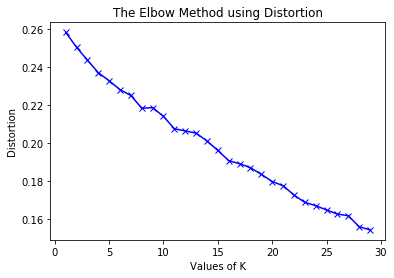

In [72]:

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [73]:
# set number of clusters
kclusters = 10

london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([6, 5, 6, 7, 7, 1, 7, 2, 4, 7])

In [74]:
kmeans.labels_

array([6, 5, 6, 7, 7, 1, 7, 2, 4, 7, 7, 7, 7, 0, 7, 6, 7, 7, 5, 0, 7, 7,
       7, 7, 4, 7, 7, 9, 7, 7, 7, 7, 5, 1, 1, 7, 7, 7, 7, 7, 1, 7, 7, 1,
       1, 4, 7, 1, 1, 4, 7, 7, 7, 1, 7, 7, 1, 7, 7, 7, 7, 7, 1, 1, 5, 7,
       1, 7, 3, 7, 7, 7, 8, 1, 7, 7, 5, 7, 7, 1, 1, 7, 7, 7, 1, 7, 7, 4,
       7, 5, 6, 7, 4, 7, 7, 1, 7, 1, 7, 3, 5, 7, 1, 7, 7, 7, 7, 3, 5, 7,
       5])

In [79]:
neighborhoods_venues_sorted.rename(columns={'Neighborhood': "District Name"}, inplace=True)

In [83]:
neighborhoods_venues_sorted

,Cluster Labels,District Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,6,Abbey Wood,Supermarket,Historic Site,Train Station,Coffee Shop,Platform,Zoo Exhibit,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant
1,5,Acton,Grocery Store,Indian Restaurant,Train Station,Breakfast Spot,Park,Fish Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
2,6,Anerley,Supermarket,Convenience Store,Fast Food Restaurant,Hotel,Grocery Store,Zoo Exhibit,Fish Market,Exhibit,Falafel Restaurant,Farmers Market
3,7,Balham,Coffee Shop,Pub,Bakery,Grocery Store,Burger Joint,Caucasian Restaurant,Shop & Service,Breakfast Spot,Fish & Chips Shop,Gastropub
4,7,Barnes,Pub,Farmers Market,Park,Italian Restaurant,Community Center,French Restaurant,Movie Theater,Nature Preserve,Food & Drink Shop,Breakfast Spot
...,...,...,...,...,...,...,...,...,...,...,...,...
106,7,Wimbledon,Pub,Bar,Indian Restaurant,Sushi Restaurant,Burger Joint,Sandwich Place,Brazilian Restaurant,Mexican Restaurant,Movie Theater,Scenic Lookout
107,3,Winchmore Hill,Italian Restaurant,Café,Soccer Field,Supermarket,Grocery Store,Food Court,Food & Drink Shop,Food Truck,Fountain,Exhibit
108,5,Wood Green,Park,Italian Restaurant,Light Rail Station,Grocery Store,Bar,Indian Restaurant,Department Store,Dessert Shop,French Restaurant,Fountain
109,7,Woodford and South Woodford,Pub,Seafood Restaurant,Bridal Shop,Bar,Liquor Store,Convenience Store,BBQ Joint,Coffee Shop,Fish & Chips Shop,Falafel Restaurant


In [82]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)



ValueError: cannot insert Cluster Labels, already exists

In [84]:
london_merged = london

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('District Name'), on='District Name')

london_merged.head() # check the last columns!

,index,District,District Name,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Eastern,Head district,E1,51.52022,-0.05431,7,Coffee Shop,Pub,Café,Hotel,Zoo Exhibit,Cocktail Bar,Vietnamese Restaurant,Theater,Burger Joint,Garden
1,1,Eastern,Bethnal Green,E2,51.52669,-0.06257,1,Café,Pub,Coffee Shop,Convenience Store,Brewery,Park,Cocktail Bar,Fast Food Restaurant,Thrift / Vintage Store,Bar
2,2,Eastern,Bow,E3,51.52702,-0.02594,4,Pub,Locksmith,Light Rail Station,Burger Joint,Park,Grocery Store,Bar,Bus Stop,Rental Car Location,Diner
3,3,Eastern,Chingford,E4,51.61780,-0.00934,6,Gym,Gym / Fitness Center,American Restaurant,English Restaurant,Pizza Place,Fish & Chips Shop,Event Space,Exhibit,Falafel Restaurant,Farmers Market
4,4,Eastern,Clapton,E5,51.55897,-0.05323,5,Grocery Store,Pub,Park,Cocktail Bar,Turkish Restaurant,Bus Stop,Café,Burger Joint,Garden,Martial Arts School


We visualize the clusters in a map.

In [85]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [86]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['District Name'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Examine Clusters**
<br>Now, the client can examine each cluster and determine the discriminating venue categories that distinguish them. Based on their preferences, they can them make a more informed decision about which areas suit them best as new location to live.

In [87]:
london_merged

,index,District,District Name,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Eastern,Head district,E1,51.52022,-0.05431,7,Coffee Shop,Pub,Café,Hotel,Zoo Exhibit,Cocktail Bar,Vietnamese Restaurant,Theater,Burger Joint,Garden
1,1,Eastern,Bethnal Green,E2,51.52669,-0.06257,1,Café,Pub,Coffee Shop,Convenience Store,Brewery,Park,Cocktail Bar,Fast Food Restaurant,Thrift / Vintage Store,Bar
2,2,Eastern,Bow,E3,51.52702,-0.02594,4,Pub,Locksmith,Light Rail Station,Burger Joint,Park,Grocery Store,Bar,Bus Stop,Rental Car Location,Diner
3,3,Eastern,Chingford,E4,51.61780,-0.00934,6,Gym,Gym / Fitness Center,American Restaurant,English Restaurant,Pizza Place,Fish & Chips Shop,Event Space,Exhibit,Falafel Restaurant,Farmers Market
4,4,Eastern,Clapton,E5,51.55897,-0.05323,5,Grocery Store,Pub,Park,Cocktail Bar,Turkish Restaurant,Bus Stop,Café,Burger Joint,Garden,Martial Arts School
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,116,Paddington,Shepherds Bush,W12,51.50645,-0.23691,5,Grocery Store,Pub,Café,Fast Food Restaurant,Gastropub,Bus Stop,Park,Tea Room,Escape Room,Deli / Bodega
116,117,Paddington,West Ealing,W13,51.51453,-0.31951,5,Grocery Store,Indian Restaurant,Persian Restaurant,Turkish Restaurant,Doner Restaurant,Sandwich Place,Fast Food Restaurant,Fish Market,Bus Stop,Gastropub
117,118,Paddington,West Kensington,W14,51.49568,-0.20993,7,Pub,Hotel,Indian Restaurant,Grocery Store,Persian Restaurant,Convention Center,Restaurant,Supermarket,Cocktail Bar,Coffee Shop
118,119,Western Central,Head district,WC1,51.52450,-0.12273,7,Coffee Shop,Pub,Café,Hotel,Zoo Exhibit,Cocktail Bar,Vietnamese Restaurant,Theater,Burger Joint,Garden


In [88]:
london_merged.shape

(120, 17)

In [62]:
list(range(5, toronto_merged.shape[1]))

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [90]:
#Cluster 0
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[1]+ [2] + list(range(7, london_merged.shape[1]))]]

,District,District Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,North Western,Cricklewood,Gym / Fitness Center,Hardware Store,Clothing Store,Supermarket,Fish Market,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
62,South Eastern,Charlton,Supermarket,Clothing Store,Coffee Shop,Pub,Arts & Crafts Store,Shopping Plaza,Thai Restaurant,Pharmacy,Auto Garage,Gym / Fitness Center


In [91]:
#Cluster 1
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[1]+ [2] + list(range(7, london_merged.shape[1]))]]

,District,District Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Eastern,Bethnal Green,Café,Pub,Coffee Shop,Convenience Store,Brewery,Park,Cocktail Bar,Fast Food Restaurant,Thrift / Vintage Store,Bar
8,Eastern,Homerton,Park,Pub,Gastropub,Café,Bakery,Italian Restaurant,Bagel Shop,Historic Site,Lake,Middle Eastern Restaurant
10,Eastern,Leytonstone,Café,Pub,Grocery Store,Pizza Place,Pharmacy,Park,Bakery,Diner,Restaurant,Coffee Shop
13,Eastern,Poplar,Park,Grocery Store,Sandwich Place,Chinese Restaurant,English Restaurant,Café,Coffee Shop,Light Rail Station,Falafel Restaurant,Farmers Market
15,Eastern,Victoria Docks and North Woolwich,Café,Middle Eastern Restaurant,Hotel,Gym / Fitness Center,Dry Cleaner,Science Museum,Scenic Lookout,Thai Restaurant,Steakhouse,Grocery Store
27,Northern,Highbury,Café,Park,Middle Eastern Restaurant,Tennis Court,Thai Restaurant,Bar,Cheese Shop,Grocery Store,Bookstore,Fish & Chips Shop
30,Northern,Hornsey,Café,Pub,Coffee Shop,French Restaurant,Italian Restaurant,Turkish Restaurant,Record Shop,Pizza Place,Caribbean Restaurant,Movie Theater
32,Northern,Muswell Hill,Café,Deli / Bodega,Grocery Store,Bakery,Pub,Restaurant,English Restaurant,Coffee Shop,Seafood Restaurant,Organic Grocery
37,Northern,South Tottenham,Grocery Store,Pub,Pizza Place,South American Restaurant,Café,Park,Train Station,Coffee Shop,Hardware Store,Fried Chicken Joint
38,Northern,Stoke Newington,Pub,Café,Pizza Place,Cocktail Bar,Italian Restaurant,Fish & Chips Shop,Organic Grocery,Park,Fruit & Vegetable Store,Bar


In [92]:
#Cluster 2
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[1]+ [2] + list(range(7, london_merged.shape[1]))]]

,District,District Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
58,South Eastern,Blackheath,Pub,Zoo Exhibit,Flea Market,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop


In [93]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[1]+ [2] + list(range(7, london_merged.shape[1]))]]

,District,District Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,Northern,Winchmore Hill,Italian Restaurant,Café,Soccer Field,Supermarket,Grocery Store,Food Court,Food & Drink Shop,Food Truck,Fountain,Exhibit
93,South Western,West Brompton,Italian Restaurant,Cocktail Bar,Juice Bar,Bakery,Sandwich Place,French Restaurant,Café,Multiplex,Restaurant,Gym
114,Paddington,Notting Hill,Italian Restaurant,Bakery,Restaurant,Bookstore,Clothing Store,Movie Theater,Gastropub,Diner,Market,Cocktail Bar


In [94]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[1]+ [2] + list(range(7, london_merged.shape[1]))]]

,District,District Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Eastern,Bow,Pub,Locksmith,Light Rail Station,Burger Joint,Park,Grocery Store,Bar,Bus Stop,Rental Car Location,Diner
28,Northern,Highgate,Pub,Coffee Shop,Italian Restaurant,Bakery,Gastropub,French Restaurant,Park,Pizza Place,Plaza,Pool
39,Northern,Tottenham,Pub,Café,Park,Roller Rink,Gas Station,Grocery Store,Fish & Chips Shop,Exhibit,Falafel Restaurant,Farmers Market
66,South Eastern,Kennington,Pub,Coffee Shop,Italian Restaurant,Café,Indian Restaurant,Motorcycle Shop,Pizza Place,Park,Museum,Bar
77,South Eastern,East Dulwich,Bar,Pub,Grocery Store,Bus Stop,Park,Gastropub,Flea Market,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
99,Battersea,Streatham,Pub,Diner,Supermarket,Park,Video Game Store,Pizza Place,Playground,Bar,Burger Joint,Discount Store


In [95]:
london_merged.loc[london_merged['Cluster Labels'] == 5, london_merged.columns[[1]+ [2] + list(range(7, london_merged.shape[1]))]]

,District,District Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Eastern,Clapton,Grocery Store,Pub,Park,Cocktail Bar,Turkish Restaurant,Bus Stop,Café,Burger Joint,Garden,Martial Arts School
6,Eastern,Forest Gate,Grocery Store,Bus Stop,Fast Food Restaurant,Fish & Chips Shop,Pub,Indian Restaurant,Hotel,Bakery,Train Station,Comfort Food Restaurant
33,Northern,New Southgate,Grocery Store,Playground,Beer Bar,Bus Stop,Train Station,Fish & Chips Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market
44,Northern,Wood Green,Park,Italian Restaurant,Light Rail Station,Grocery Store,Bar,Indian Restaurant,Department Store,Dessert Shop,French Restaurant,Fountain
73,South Eastern,Woolwich,Fish & Chips Shop,Bus Stop,Indian Restaurant,Chinese Restaurant,Child Care Service,Middle Eastern Restaurant,Convenience Store,Grocery Store,Zoo Exhibit,Farmers Market
83,South Eastern,Thamesmead,Sports Club,Daycare,Bus Stop,Home Service,Flower Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market
106,Paddington,Acton,Grocery Store,Indian Restaurant,Train Station,Breakfast Spot,Park,Fish Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
115,Paddington,Shepherds Bush,Grocery Store,Pub,Café,Fast Food Restaurant,Gastropub,Bus Stop,Park,Tea Room,Escape Room,Deli / Bodega
116,Paddington,West Ealing,Grocery Store,Indian Restaurant,Persian Restaurant,Turkish Restaurant,Doner Restaurant,Sandwich Place,Fast Food Restaurant,Fish Market,Bus Stop,Gastropub


In [96]:
london_merged.loc[london_merged['Cluster Labels'] == 6, london_merged.columns[[1]+ [2] + list(range(7, london_merged.shape[1]))]]

,District,District Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Eastern,Chingford,Gym,Gym / Fitness Center,American Restaurant,English Restaurant,Pizza Place,Fish & Chips Shop,Event Space,Exhibit,Falafel Restaurant,Farmers Market
53,North Western,The Hyde,Bus Stop,Asian Restaurant,Pub,Auto Workshop,Café,Coffee Shop,Hotel,Hookah Bar,Supermarket,Farmers Market
57,South Eastern,Abbey Wood,Supermarket,Historic Site,Train Station,Coffee Shop,Platform,Zoo Exhibit,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant
75,South Eastern,Anerley,Supermarket,Convenience Store,Fast Food Restaurant,Hotel,Grocery Store,Zoo Exhibit,Fish Market,Exhibit,Falafel Restaurant,Farmers Market


In [97]:
london_merged.loc[london_merged['Cluster Labels'] == 7, london_merged.columns[[1]+ [2] + list(range(7, london_merged.shape[1]))]]

,District,District Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Eastern,Head district,Coffee Shop,Pub,Café,Hotel,Zoo Exhibit,Cocktail Bar,Vietnamese Restaurant,Theater,Burger Joint,Garden
5,Eastern,East Ham,Clothing Store,Fast Food Restaurant,Indian Restaurant,Gym Pool,Coffee Shop,Electronics Store,Park,Supermarket,Grocery Store,Bakery
7,Eastern,Hackney,Pub,Modern European Restaurant,Brewery,Coffee Shop,Bakery,Italian Restaurant,Park,Café,Burger Joint,Church
9,Eastern,Leyton,Pub,Café,Platform,Grocery Store,Metro Station,Supermarket,Chinese Restaurant,Optical Shop,Clothing Store,Fast Food Restaurant
11,Eastern,Manor Park,Asian Restaurant,Restaurant,Gas Station,Gym / Fitness Center,Pub,Fountain,Food Truck,French Restaurant,Food Court,Food & Drink Shop
...,...,...,...,...,...,...,...,...,...,...,...,...
111,Paddington,Kensington,Indian Restaurant,Hotel,Juice Bar,Bakery,Clothing Store,French Restaurant,Pub,Spa,Café,Chinese Restaurant
112,Paddington,Maida Hill,Coffee Shop,Pizza Place,Café,Deli / Bodega,Italian Restaurant,Tennis Court,Canal,Pub,Fast Food Restaurant,Fish & Chips Shop
117,Paddington,West Kensington,Pub,Hotel,Indian Restaurant,Grocery Store,Persian Restaurant,Convention Center,Restaurant,Supermarket,Cocktail Bar,Coffee Shop
118,Western Central,Head district,Coffee Shop,Pub,Café,Hotel,Zoo Exhibit,Cocktail Bar,Vietnamese Restaurant,Theater,Burger Joint,Garden


In [98]:
london_merged.loc[london_merged['Cluster Labels'] == 8, london_merged.columns[[1]+ [2] + list(range(7, london_merged.shape[1]))]]

,District,District Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Eastern,Plaistow,Café,Bus Station,Gym,Convenience Store,Flower Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market


In [99]:
london_merged.loc[london_merged['Cluster Labels'] == 9, london_merged.columns[[1]+ [2] + list(range(7, london_merged.shape[1]))]]

,District,District Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,South Eastern,Eltham,Bus Stop,Golf Course,Construction & Landscaping,Park,Historic Site,Zoo Exhibit,Fish & Chips Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant


## Results and Discussion <a name="results"></a>

Our analysis shows the 10 most common venues in each district area in London.

10 clusters of relatively similar locations were established, based on these common venues.
Cluster 7, containing 73 Districts, is by far the cluster with more locations. Common venues include: coffee shops, pubs, cafés,bakeries, gyms and restaurants. 

At this stage, the data should be presented to the client to help inform their decision in choosing their home location.
Further study of the results can also be done after receiving feedback from the client. For example, if the presence of a garden is a must for the client, our search can be refined. A Heatmap could also facilitate visualisation of frequencies of certain venues in London.


## Conclusion <a name="conclusion"></a>

The purpose of this project was to perform an exploratory data analysis of the most common venues in London districts, in order to aid stakeholders in narrowing down the search for the optimal home location.

By calculating venue frequency (using data from Foursquare), we have first identified most common venue categories for each district. We have then created clusters of districts with similar common venues. Clustering was performed in order to create major zones of interest.

Final decision on optimal district will be made by stakeholders based on specific characteristics of neighborhoods and locations in every zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.